In [2]:
# -*- coding: utf-8 -*-
import re
import os
from unidecode import unidecode
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.manifold import MDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

: 

**Hàm tách từ và chuẩn hóa văn bản**

In [3]:
def tokenize_and_stem(text):
    stemmer = SnowballStemmer("english")
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
            
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

**Hàm tách từ**

In [4]:
def tokenize_only(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

**Hàm thực hiện tiền xử lý dữ liệu văn bản:**

In [5]:
def TextPreprocessing(corpus):
    stopwords = nltk.corpus.stopwords.words("english")
    stemmer = SnowballStemmer("english")
    
    for document in corpus:
        index = corpus.index(document)
        
        corpus[index] = corpus[index].replace('XXXX', '')        
        corpus[index] = corpus[index].replace(u'\ufffd', '')   # Replaces the ASCII symbol with ''
        corpus[index] = corpus[index].replace(',', '')          # Removes commas
        corpus[index] = corpus[index].rstrip('\n')              # Removes line breaks
        corpus[index] = corpus[index].casefold()                # Makes all letters lowercase
        
        corpus[index] = re.sub('\W_',' ', corpus[index])        # removes specials characters and leaves only words
        corpus[index] = re.sub("\S*\d\S*"," ", corpus[index])   # removes numbers and words concatenated with numbers IE h4ck3r. Removes road names such as BR-381.
        corpus[index] = re.sub("\S*@\S*\s?"," ", corpus[index]) # removes emails and mentions (words with @)
        corpus[index] = re.sub(r'http\S+', '', corpus[index])   # removes URLs with http
        corpus[index] = re.sub(r'www\S+', '', corpus[index])    # removes URLs with www

        listOfTokens = word_tokenize(corpus[index])
        listOfTokens = [token for token in listOfTokens if token not in stopwords]
        listOfTokens = [stemmer.stem(token) for token in listOfTokens] #applyStemming(listOfTokens, param_stemmer)        
        
        corpus[index]   = " ".join(listOfTokens)
        corpus[index] = unidecode(corpus[index])
    return corpus

<>:14: SyntaxWarning: invalid escape sequence '\W'
<>:15: SyntaxWarning: invalid escape sequence '\S'
<>:16: SyntaxWarning: invalid escape sequence '\S'
<>:14: SyntaxWarning: invalid escape sequence '\W'
<>:15: SyntaxWarning: invalid escape sequence '\S'
<>:16: SyntaxWarning: invalid escape sequence '\S'
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_15768\3454294928.py:14: SyntaxWarning: invalid escape sequence '\W'
  corpus[index] = re.sub('\W_',' ', corpus[index])        # removes specials characters and leaves only words
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_15768\3454294928.py:15: SyntaxWarning: invalid escape sequence '\S'
  corpus[index] = re.sub("\S*\d\S*"," ", corpus[index])   # removes numbers and words concatenated with numbers IE h4ck3r. Removes road names such as BR-381.
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_15768\3454294928.py:16: SyntaxWarning: invalid escape sequence '\S'
  corpus[index] = re.sub("\S*@\S*\s?"," ", corpus[index]) # removes emails and mentions (w

**Đọc dữ liệu:** Lấy dữ liệu từ file consumer_complaints.csv


In [6]:
def Read_Data():    
    # Doc du lieu
    # path=os.path.dirname(__file__)
        
    path = os.getcwd()
    Data = pd.read_csv(path + "\\Data\\consumer_complaints.csv",encoding='latin-1', low_memory=False)
    # Thiet lap du lieu
    Data = Data[['consumer_complaint_narrative']]
    Data = Data[pd.notnull(Data['consumer_complaint_narrative'])]
    
    print(Data[:10])
    
    # Chon 1000 dong du lieu de xu ly
    Data_sample=Data.sample(1000)
    print(Data_sample)

    # Convert dataframe to list
    complaints = Data_sample['consumer_complaint_narrative'].tolist()    
    return complaints

**Hàm xây dựng Vector TF-IDF**

In [7]:
def Vectorize_TFIDF(corpus):
    # Xay dung vector dac trung TF-IDF
    tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,min_df=0.2, use_idf=True, ngram_range=(1,3))
    X = tfidf_vectorizer.fit_transform(corpus)
    terms = tfidf_vectorizer.get_feature_names_out()
    print(X.shape)    
    return X, terms

**Hàm tìm số cụm K tối ưu bằng phương pháp Elbow**

In [8]:
def Elbow_Score(X, K_max):
    wcss = []
    for i in range(2, K_max):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)

    plt.plot(range(2, 11), wcss)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

**Hàm tìm số cụm K tối ưu bằng phương pháp Silhouette**

In [9]:
def Silhouette_Score(X,K_max):
    silhouette_scores = []
    for i in range(2, K_max):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(X)
        labels = kmeans.labels_
        score = silhouette_score(X, labels)
        silhouette_scores.append(score)
        
    # Plot the Silhouette Scores    
    plt.plot(range(2, 11), silhouette_scores)
    plt.title('Silhouette Score')
    plt.xlabel('Number of clusters')
    plt.ylabel('Score')
    plt.show()

**Hàm trình diễn dữ liệu**

In [10]:
def Presentation_Data(complaints,km,num_clusters):
    ranks = []
    for i in range(1, len(complaints)+1):
        ranks.append(i)
        
    clusters = km.labels_.tolist()
    complaints_data = { 'rank': ranks, 'complaints': complaints,'cluster': clusters }
    frame = pd.DataFrame(complaints_data, index = [clusters] , columns =['rank', 'cluster'])

    # Thong ke so luong van ban o moi cum
    print("Numbers of Docs per cluster:")
    print(frame['cluster'].value_counts().sort_index())

    # Xac dinh 5 tu o gan tam cua moi cum nhat    
    totalvocab_stemmed = []
    totalvocab_tokenized = []
    for i in complaints:
        allwords_stemmed = tokenize_and_stem(i)
        totalvocab_stemmed.extend(allwords_stemmed)
        allwords_tokenized = tokenize_only(i)
        totalvocab_tokenized.extend(allwords_tokenized)
        
    vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index =totalvocab_stemmed)

    #sort cluster centers by proximity to centroid
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    print("Top 5 words closest to the cluster centers:")
    for i in range(num_clusters):
        print("Cluster %d words: " % i, end='')
        for ind in order_centroids[i, :6]:
            print(vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0], end=', ')
        print()        

    # Bieu dien tren bang do nhiet
    similarity_distance = 1 - cosine_similarity(X)

    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
    pos = mds.fit_transform(similarity_distance)
    xs, ys = pos[:, 0], pos[:, 1]

    # Thiet lap mau cho moi cum
    cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e', 5: '#2300FF', 6: '#FF88AE', 7: '#FFED88', 8: '#FF88FA', 9: '#88FF9F'}    

    # Thiet lap ten cho moi cum
    cluster_names=dict()
    for i in range(0,num_clusters):
        cluster_names[i]= "Cluster" + str(i)

    df = pd.DataFrame(dict(x=xs, y=ys, label=clusters))
    groups = df.groupby('label')

    # Set up plot
    fig, ax = plt.subplots(figsize=(17, 9))
    for name, group in groups:
        ax.plot(group.x, group.y, marker="o", linestyle='',ms=20,label=cluster_names[name], color=cluster_colors[name],mec='none')
        ax.set_aspect('auto')
        ax.tick_params(axis= 'x', which='both', bottom='off', top='off', labelbottom='off')
        ax.tick_params(axis= 'y', which='both', left='off', top='off',labelleft='off')
        
    ax.legend(numpoints=1)
    plt.show()

In [11]:
#######################################################################################
# Đọc dữ liệu
complaints=Read_Data()

                             consumer_complaint_narrative
190126  XXXX has claimed I owe them {$27.00} for XXXX ...
190135  Due to inconsistencies in the amount owed that...
190155  In XX/XX/XXXX my wages that I earned at my job...
190207  I have an open and current mortgage with Chase...
190208  XXXX was submitted XX/XX/XXXX. At the time I s...
190237  Experian is reporting my OPEN and CURRENT Mort...
190238  This complaint is against Wells Fargo Bank for...
190251  I spoke to XXXX of green tree representatives ...
190263  i opened XXXX Bank of America credit cards 15-...
190264  I applied for a loan with XXXX XXXX and had pu...
                             consumer_complaint_narrative
522154  I had a credit card which I was unable to make...
260125  I had a bank account closed with Bank of Ameri...
264634  I have been paying for an insurance policy wit...
299936  I receive a monthly social security benefit ch...
282846  I have been writing the XXXX credit agencies t...
...           

In [12]:
#Tiền xử lý
complaints=TextPreprocessing(complaints)

In [13]:
# Trích xuất đặc trưng văn bản
X, terms= Vectorize_TFIDF(complaints)

(1000, 34)


**Giảm chiều cho dữ liệu bằng phương pháp TruncatedSVD**

In [14]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=10, random_state=42)
X = svd.fit_transform(X)

**Chấm điểm giá trị K của thuật toán K-Means - Phương pháp Elbow (Khuỷu tay)**

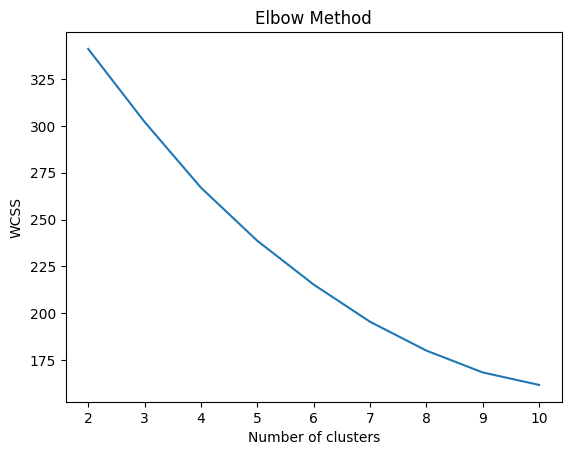

In [15]:
K_max=11
Elbow_Score(X,K_max)

**Chấm điểm giá trị K của thuật toán K-Means - Phương pháp Silhouette Score (Điểm bóng)**

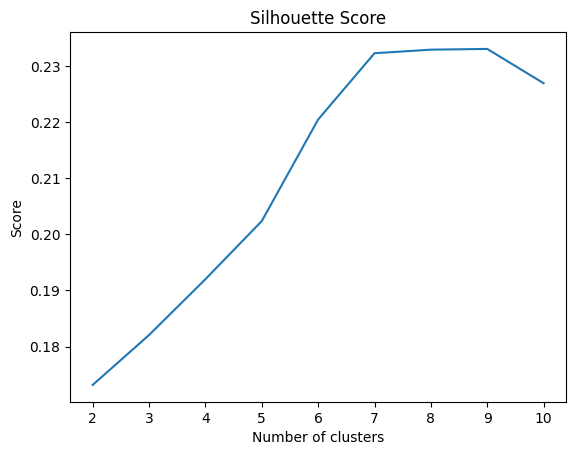

In [16]:
K_max=11
Silhouette_Score(X,K_max)

**Chạy thuật toán K-Means**
Dựa trên kết quả chấm điểm tối ưu giá trị K, ta quyết định chọn K=8 (num_clusters) -- Test K=5

In [17]:
num_clusters = 5
km = KMeans(n_clusters=num_clusters, n_init=5).fit(X)

Numbers of Docs per cluster:
cluster
0    199
1    239
2    259
3    180
4    123
Name: count, dtype: int64
Top 5 words closest to the cluster centers:
Cluster 0 words: account, bank, collect, credit, credit, contact, 
Cluster 1 words: account, also, bank, call, collect, contact, 
Cluster 2 words: account, call, contact, credit, credit, collect, 
Cluster 3 words: account, ask, compani, credit, credit, contact, 
Cluster 4 words: account, compani, also, credit, collect, credit, 


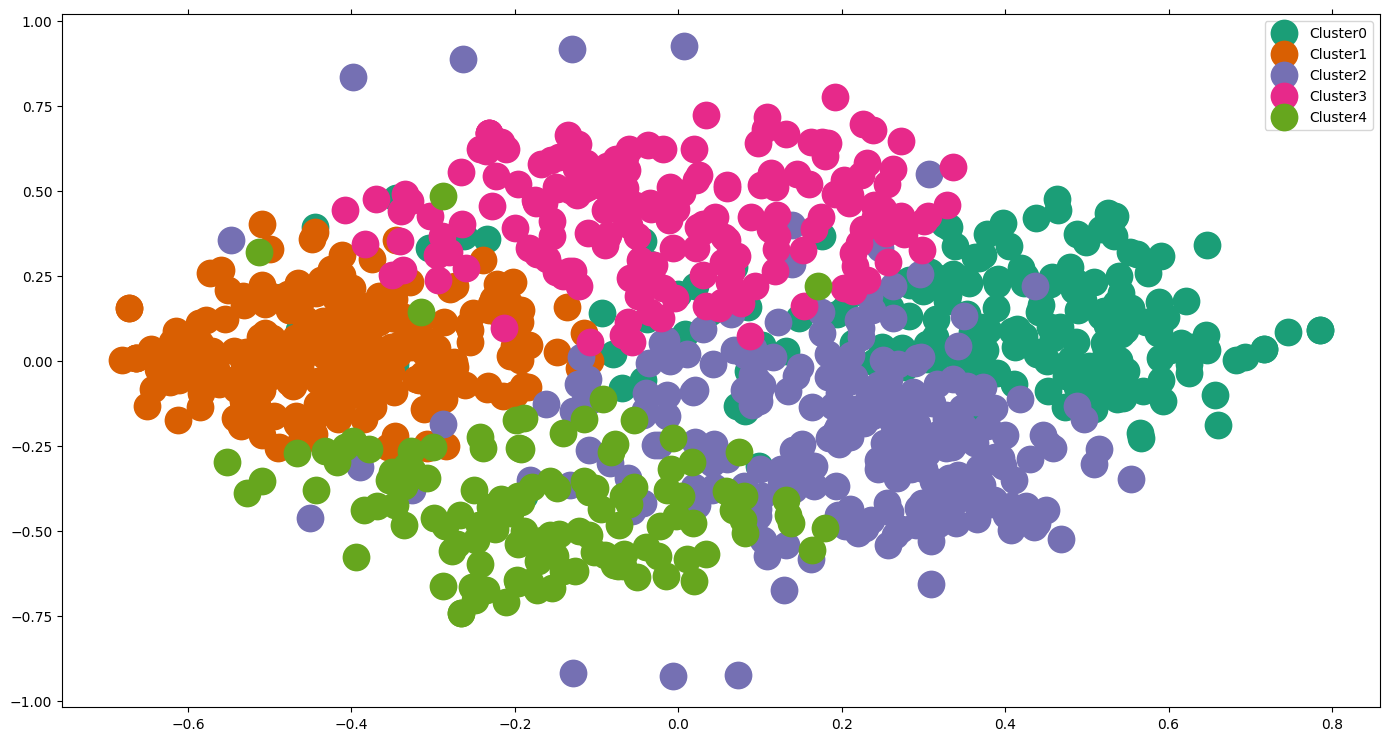

In [18]:
# Biểu diễn dữ liệu
Presentation_Data(complaints,km,num_clusters)